# GDPR Face Blurring/Removal Example

In this simple example, we show how the MAX-Facial-Recognizer model can be used to blur out faces of specific people from an image. Alternatively, we can use this to only show whitelisted faces. A recent relevant use case is the GDPR compliance/enforcement which may require enterprises/businesses to have explicit permission from people before using their image, else they'd have to blur out those faces.

## Contents of this demo

We first visualize the test image and pass it through the MAX-Facial-Recognizer model to get all the faces/bboxes from the image. We then visualize the bboxes to verify the model worked as intended. 
Now we're given a couple of "white listed" faces which we are allowed to use/have on the image. We then generate embeddings for these faces and compare with all the generated face embeddings from our test images. We have set a hueristic threshold/distance of `1.05` here but it can be emperically determined from experiments and fine tuned per requirement. We then blur out/ remove any face which is beyond the threshold distance (_l2_ norm) from our white listed face embeddings. 

## Extensions

This is just a simple example which uses hard coded thresholds to illustrate the use of this model. Obviously, with more data, one can build a SVM classifier/Deep Neural Network to perform classification with much higher accuracy.

In [1]:
%%bash
pip install -q numpy scipy matplotlib Pillow requests

In [2]:
from PIL import Image
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import requests
from scipy.spatial.distance import cosine as cosine
matplotlib.rcParams['figure.dpi']= 400
matplotlib.rc("savefig", dpi=400)

In [3]:
# Point this to the right URL. This is the default URL.
url = 'http://localhost:5000/model/predict'

def facenet(input_img):
    """
    Takes in input image file path and generates face embeddings/bboxes.
    """
    files = {'image': ('image.jpg',open(input_img,'rb'), 'images/jpeg')}
    r = requests.post(url, files=files).json()
    
    return r

# Visualizing the test image

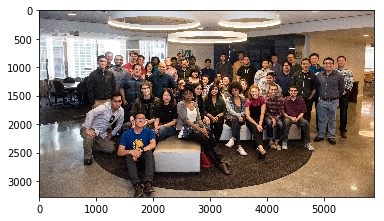

In [4]:
# Visualizing our test image. Our objective is to blur/remove blacklisted faces.
plt.imshow(plt.imread('assets/codait.jpeg'))

# Detecting all faces in the test image

In [5]:
# Detecting faces and generating embeddings from the FaceNet model.
preds = facenet('assets/codait.jpeg')

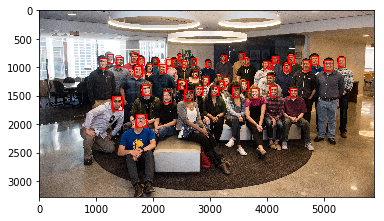

In [6]:
# Visualizing ALL the detected Faces

im = np.array(Image.open('assets/codait.jpeg'), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

rectangles = []
# Create a Rectangle patch
for pred in preds['predictions']:
    if(pred['probability']>0.95):
        bbox = pred['detection_box']
        rectangle = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        rectangles.append(rectangle)
        ax.add_patch(rectangle)

plt.show()

# Visualizing white listed faces and generating embeddings

Let's say we have explicit permission to retain only these two faces. We demonstrate how we can implement such a face filter.


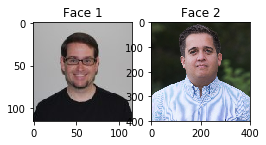

In [7]:
# The face we want to blur out/censor
face_to_retain1 = 'assets/Bryan.png'
face_to_retain2 = 'assets/Luciano.png'

fig = plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(plt.imread(face_to_retain1))
plt.title("Face 1")
plt.subplot(1, 3, 2)
plt.imshow(plt.imread(face_to_retain2))
plt.title("Face 2")

plt.show()

In [8]:
# Generating embeddings for our white listed faces

preds1 = facenet(face_to_retain1)
embed1 = preds1['predictions'][0]['embedding']

preds2 = facenet(face_to_retain2)
embed2 = preds2['predictions'][0]['embedding']


# Removing all other faces

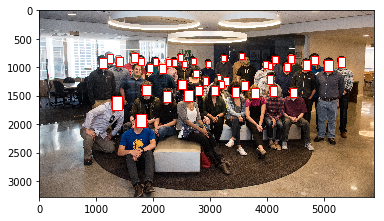

In [9]:
# Filtering out non white listed faces

im = np.array(Image.open('assets/codait.jpeg'), dtype=np.uint8)
threshold = 1.05
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for i,pred in enumerate(preds['predictions']):
    if(pred['probability']<0.95):
        continue
    else:
        if(np.linalg.norm(np.array(pred['embedding'])-np.array(embed1))>threshold and np.linalg.norm(np.array(pred['embedding'])-np.array(embed2))>threshold):
            bbox = pred['detection_box']
            rectangle = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='white')
            ax.add_patch(rectangle)
        else:
            bbox = pred['detection_box']
            rectangle = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=0.3,edgecolor='g', facecolor='none')
            ax.add_patch(rectangle)

plt.show()